# DSCI 632 Final Project

Nick Babcock
<p>Amui Gayle
<p>Kunal Chhabria

## <u>Forecasting Major League Baseball Statistics with Machine Learning<u/>


<p> A baseball season consists of 162 games which is about seven months long, and each player's statistics are updated every time they play in a game. In this project, we have built prediction models to predict a player's 2021 final season ending statistics. We will do this by evaluating their performance and recorded statistics from previous seasons. These statistics will be used to train our models and ultimately predict the outcome of each players' 2021 season statistics. We will then be able to check against the real values of the 2021 season statistics in order to test and validate the performance of our models.

In [149]:
!pip install -q findspark
!pip install pyspark

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [150]:
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName("HW2").getOrCreate()
spark

In [151]:
df = spark.read.format('csv').option('header', 'true').option('inferSchema', 'true').load("/content/sample_data/battingdata.csv")

In [152]:
df.show(5, truncate= False)

+------+---------------+----+---+---+---+---+---+---+---+---+-----+-----+------+-----+-----+-----+-----+------+------+------+------+------+--------+--------+------+----------+----------+--------+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+

## Data Pre-processing

In [153]:
#check number of rows and columns in dataframe
print('Rows:', df.count(), '\n', 'Columns:', len(df.columns))

Rows: 1585 
 Columns: 314


In [154]:
from pyspark.sql.functions import col

for c in df.columns:
  n = df.filter(col(c).isNull()).count()

In [155]:
#all columns from column 29 to the end of df are null
df.select(df.columns[29:]).show(1)

+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+--

In [156]:
#drop null values
df = df.drop(*df.columns[29:])
print('\nAfter dropping null values: \n')
print('Rows:', df.count(), '\n', 'Columns:', len(df.columns))


After dropping null values: 

Rows: 1585 
 Columns: 29


In [157]:
#The string values need to be converted to float after dropping the '%'
print('Rows:', df.count(), '\n', 'Columns:', len(df.columns))
df.printSchema()

Rows: 1585 
 Columns: 29
root
 |-- Season: integer (nullable = true)
 |-- Name: string (nullable = true)
 |-- Team: string (nullable = true)
 |-- Age: integer (nullable = true)
 |-- AB: integer (nullable = true)
 |-- PA: integer (nullable = true)
 |-- H: integer (nullable = true)
 |-- HR: integer (nullable = true)
 |-- R: integer (nullable = true)
 |-- RBI: integer (nullable = true)
 |-- SB: integer (nullable = true)
 |-- AVG: double (nullable = true)
 |-- BB%: string (nullable = true)
 |-- K%: string (nullable = true)
 |-- OBP: double (nullable = true)
 |-- SLG: double (nullable = true)
 |-- ISO: double (nullable = true)
 |-- BABIP: double (nullable = true)
 |-- LD%: string (nullable = true)
 |-- GB%: string (nullable = true)
 |-- FB%: string (nullable = true)
 |-- IFFB%: string (nullable = true)
 |-- HR/FB: string (nullable = true)
 |-- O-Swing%: string (nullable = true)
 |-- Z-Swing%: string (nullable = true)
 |-- Swing%: string (nullable = true)
 |-- O-Contact%: string (nullable = 

In [158]:
# remove % symbol from percentage column values and convert the string values to float for numeric predictions
from pyspark.sql.functions import regexp_replace, col

percentage_list = ['BB%', 'K%', 'LD%', 'GB%', 'FB%', 'IFFB%', 'HR/FB', 'O-Swing%', 'Z-Swing%', 'Swing%', 'O-Contact%', 'Z-Contact%', 'Contact%']

for c in percentage_list:
  df = df.withColumn(c, regexp_replace(c, '%', ''))
  df = df.withColumn(c, col(c).cast('float'))

In [159]:
# casting all the columns that will be predicted to floats in order to handle evaluation metric scores
df = df.withColumn('HR', col('HR').cast('float'))
df = df.withColumn('RBI', col('RBI').cast('float'))
df = df.withColumn('OBP', col('OBP').cast('float'))

In [160]:
#check that our transformation was successful
df.printSchema()

root
 |-- Season: integer (nullable = true)
 |-- Name: string (nullable = true)
 |-- Team: string (nullable = true)
 |-- Age: integer (nullable = true)
 |-- AB: integer (nullable = true)
 |-- PA: integer (nullable = true)
 |-- H: integer (nullable = true)
 |-- HR: float (nullable = true)
 |-- R: integer (nullable = true)
 |-- RBI: float (nullable = true)
 |-- SB: integer (nullable = true)
 |-- AVG: double (nullable = true)
 |-- BB%: float (nullable = true)
 |-- K%: float (nullable = true)
 |-- OBP: float (nullable = true)
 |-- SLG: double (nullable = true)
 |-- ISO: double (nullable = true)
 |-- BABIP: double (nullable = true)
 |-- LD%: float (nullable = true)
 |-- GB%: float (nullable = true)
 |-- FB%: float (nullable = true)
 |-- IFFB%: float (nullable = true)
 |-- HR/FB: float (nullable = true)
 |-- O-Swing%: float (nullable = true)
 |-- Z-Swing%: float (nullable = true)
 |-- Swing%: float (nullable = true)
 |-- O-Contact%: float (nullable = true)
 |-- Z-Contact%: float (nullable = 

In [161]:
df.show(5)

+------+---------------+----+---+---+---+---+----+---+----+---+-----+---+----+-----+-----+-----+-----+----+----+----+-----+-----+--------+--------+------+----------+----------+--------+
|Season|           Name|Team|Age| AB| PA|  H|  HR|  R| RBI| SB|  AVG|BB%|  K%|  OBP|  SLG|  ISO|BABIP| LD%| GB%| FB%|IFFB%|HR/FB|O-Swing%|Z-Swing%|Swing%|O-Contact%|Z-Contact%|Contact%|
+------+---------------+----+---+---+---+---+----+---+----+---+-----+---+----+-----+-----+-----+-----+----+----+----+-----+-----+--------+--------+------+----------+----------+--------+
|  2016|A.J. Pierzynski| ATL| 39|247|259| 54| 2.0| 15|23.0|  1|0.219|2.3|11.2|0.243|0.304|0.085|0.237|20.0|50.5|29.5|  4.6|  3.1|    43.9|    77.7|  58.9|      70.1|      91.9|    82.9|
|  2021|   A.J. Pollock| LAD| 33|384|422|114|21.0| 53|69.0|  9|0.297|7.1|19.0|0.355|0.536| 0.24|0.326|21.6|39.9|38.6|  5.1| 17.8|    37.6|    73.9|  52.8|      61.4|      88.1|    77.0|
|  2017|   A.J. Pollock| ARI| 29|425|466|113|14.0| 73|49.0| 20|0.266|7

## Exploratory Data Analysis

In [162]:
df.describe().show()

+-------+------------------+---------------+-----+------------------+------------------+-----------------+------------------+------------------+-----------------+------------------+-----------------+--------------------+-----------------+------------------+--------------------+-------------------+-------------------+-------------------+------------------+-----------------+------------------+-----------------+------------------+------------------+------------------+-----------------+-----------------+-----------------+-----------------+
|summary|            Season|           Name| Team|               Age|                AB|               PA|                 H|                HR|                R|               RBI|               SB|                 AVG|              BB%|                K%|                 OBP|                SLG|                ISO|              BABIP|               LD%|              GB%|               FB%|            IFFB%|             HR/FB|          O-Swing%|        

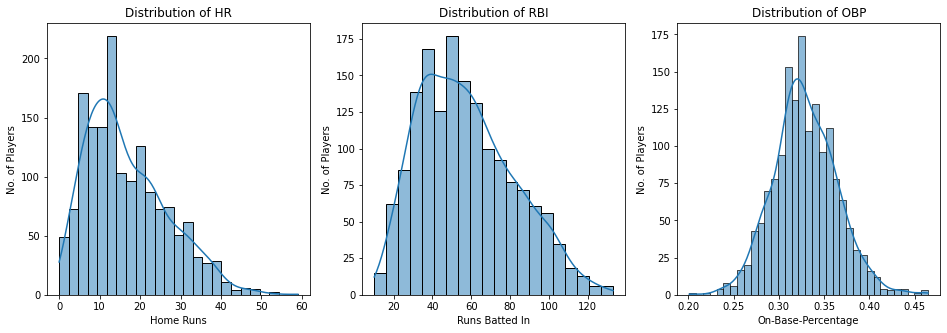

<Figure size 720x720 with 0 Axes>

In [163]:
#DISTRIBUTION OF PLAYER HR, RBI, AND OBP STATISTICS

import matplotlib.pyplot as plt
import seaborn as sns
from pyspark.sql.functions import col

main_stats = df.select("HR", "RBI", "OBP")

main_stats_pd = main_stats.toPandas()

fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(16, 5))
sns.histplot(data=main_stats_pd, x="HR", ax=ax[0], kde=True)
sns.histplot(data=main_stats_pd, x="RBI", ax=ax[1], kde=True)
sns.histplot(data=main_stats_pd, x="OBP", ax=ax[2], kde=True)

ax[0].set(title="Distribution of HR", xlabel="Home Runs", ylabel = 'No. of Players')
ax[1].set(title="Distribution of RBI", xlabel="Runs Batted In", ylabel = 'No. of Players')
ax[2].set(title="Distribution of OBP", xlabel="On-Base-Percentage", ylabel = 'No. of Players')

plt.figure(figsize=(10, 10))

plt.show()

Text(0.5, 1.0, 'Distribution of Player Ages')

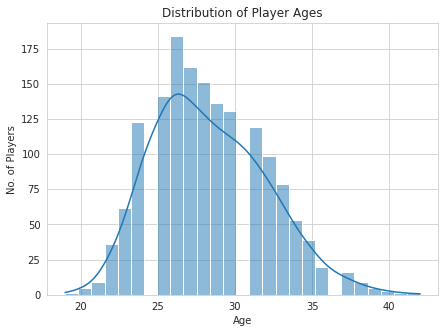

In [164]:
#DISTRIBUTION OF PLAYER AGES

sns.set_style("whitegrid")

df_pandas = df.toPandas()

fig, ax = plt.subplots(figsize=(7, 5))
sns.histplot(data=df_pandas, x="Age", kde=True, ax=ax)
ax.set_ylabel('No. of Players')
plt.title("Distribution of Player Ages")

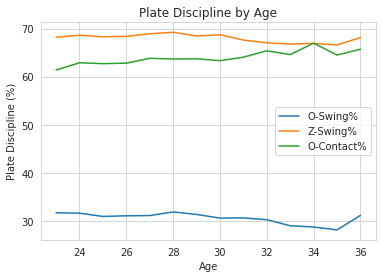

In [165]:
# PLOTTING THE RELATIONSHIP BETWEEN A PLAYER'S DISCIPLINE AT THE PLATE AND HIS AGE
from pyspark.sql.functions import mean
from pyspark.sql.functions import col

# Filter the dataframe to include only ages 23 to 36 to eliminate outliers
df_ages = df.filter(col('Age').between(23, 36))

# Grouping the filtered dataframe by age
age_groups = df_ages.groupBy('Age')

# Calculate the mean values for each age group
o_swing_means = age_groups.mean('O-Swing%').orderBy('Age')
z_swing_means = age_groups.mean('Z-Swing%').orderBy('Age')
o_contact_means = age_groups.mean('O-Contact%').orderBy('Age')

# Converting the means to Pandas and then plotting the means
o_swing_means = o_swing_means.toPandas()
z_swing_means = z_swing_means.toPandas()
o_contact_means = o_contact_means.toPandas()

fig, ax = plt.subplots()
ax.plot(o_swing_means['Age'], o_swing_means['avg(O-Swing%)'], label='O-Swing%')
ax.plot(z_swing_means['Age'], z_swing_means['avg(Z-Swing%)'], label='Z-Swing%')
ax.plot(o_contact_means['Age'], o_contact_means['avg(O-Contact%)'], label='O-Contact%')

ax.set_xlabel('Age')
ax.set_ylabel('Plate Discipline (%)')
ax.set_title('Plate Discipline by Age')

ax.legend()

plt.show()

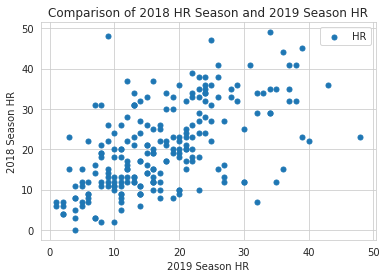

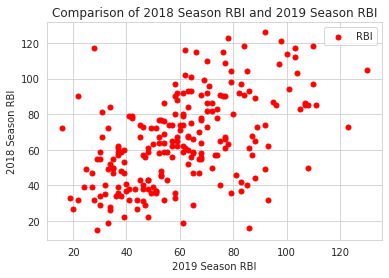

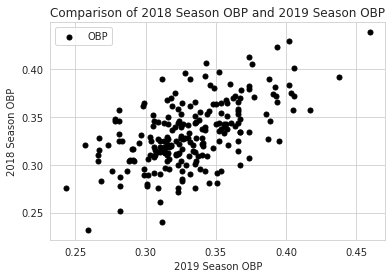

In [166]:
from pyspark.sql.functions import lag
from pyspark.sql.window import Window

# Filter the dataframe to include only players who played in both 2018 and 2019 seasons
df_compare = df.filter(col('Season').isin([2018, 2019]))
df_compare = df_compare.groupBy('Name', 'Season').agg({'HR': 'sum', 'RBI': 'sum', 'OBP': 'mean'})

# Add columns for last year's HR, RBI, and OBP
df_compare = df_compare.withColumn('2019 Season HR', lag('sum(HR)').over(Window.partitionBy('Name').orderBy('Season')))
df_compare = df_compare.withColumn('2019 Season RBI', lag('sum(RBI)').over(Window.partitionBy('Name').orderBy('Season')))
df_compare = df_compare.withColumn('2019 Season OBP', lag('avg(OBP)').over(Window.partitionBy('Name').orderBy('Season')))

# Filter out players who did not play in both seasons
df_compare = df_compare.filter(col('2019 Season HR').isNotNull() & col('2019 Season RBI').isNotNull() & col('2019 Season OBP').isNotNull())

# Plot the 2020 vs 2021 HR and RBI for each player
fig, ax = plt.subplots()
ax.scatter(df_compare.select('2019 Season HR').rdd.flatMap(lambda x: x).collect(), df_compare.select('sum(HR)').rdd.flatMap(lambda x: x).collect(), s=25, label='HR')
ax.set_xlabel('2019 Season HR')
ax.set_ylabel('2018 Season HR')
ax.set_title('Comparison of 2018 HR Season and 2019 Season HR')
#ax.legend()
ax.legend()
plt.show()

# Plot the 2020 vs 2021 RBI for each player
fig, ax = plt.subplots()
ax.scatter(df_compare.select('2019 Season RBI').rdd.flatMap(lambda x: x).collect(), df_compare.select('sum(RBI)').rdd.flatMap(lambda x: x).collect(), s=25, label='RBI', color = 'red')
ax.set_xlabel('2019 Season RBI')
ax.set_ylabel('2018 Season RBI')
ax.set_title('Comparison of 2018 Season RBI and 2019 Season RBI')
ax.legend()
plt.show()

# Plot the 2020 vs 2021 OBP for each player
fig, ax = plt.subplots()
ax.scatter(df_compare.select('2019 Season OBP').rdd.flatMap(lambda x: x).collect(), df_compare.select('avg(OBP)').rdd.flatMap(lambda x: x).collect(), s=25, label='OBP', color = 'black')
ax.set_xlabel('2019 Season OBP')
ax.set_ylabel('2018 Season OBP')
ax.set_title('Comparison of 2018 Season OBP and 2019 Season OBP')
ax.legend()
plt.show()

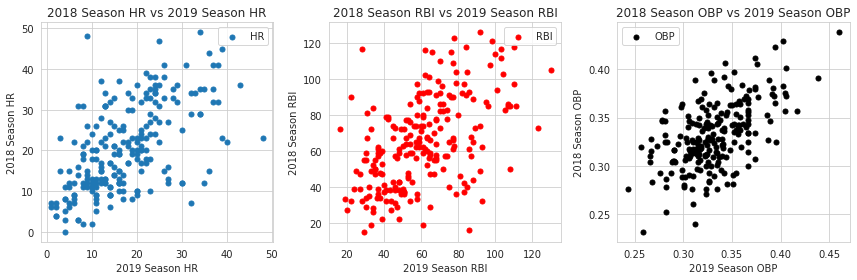

In [167]:
## same as above, just printed side by side to be pasted into paper

fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(12,4))

# Plot 1
axs[0].scatter(df_compare.select('2019 Season HR').rdd.flatMap(lambda x: x).collect(), df_compare.select('sum(HR)').rdd.flatMap(lambda x: x).collect(), s=25, label='HR')
axs[0].set_xlabel('2019 Season HR')
axs[0].set_ylabel('2018 Season HR')
axs[0].set_title('2018 Season HR vs 2019 Season HR')
axs[0].legend()

# Plot 2
axs[1].scatter(df_compare.select('2019 Season RBI').rdd.flatMap(lambda x: x).collect(), df_compare.select('sum(RBI)').rdd.flatMap(lambda x: x).collect(), s=25, label='RBI', color = 'red')
axs[1].set_xlabel('2019 Season RBI')
axs[1].set_ylabel('2018 Season RBI')
axs[1].set_title('2018 Season RBI vs 2019 Season RBI')
axs[1].legend()

# Plot 3
axs[2].scatter(df_compare.select('2019 Season OBP').rdd.flatMap(lambda x: x).collect(), df_compare.select('avg(OBP)').rdd.flatMap(lambda x: x).collect(), s=25, label='OBP', color = 'black')
axs[2].set_xlabel('2019 Season OBP')
axs[2].set_ylabel('2018 Season OBP')
axs[2].set_title('2018 Season OBP vs 2019 Season OBP')
axs[2].legend()

plt.tight_layout()
plt.show()

## Modeling

In [168]:
#Select features needed for the model and separate 2021 statistics from the data for prediction later

# These cols can be used for the basis of each model
cols = ["PA","AB", "H",
         "R", "RBI", "BB%", "ISO", 
         "BABIP", "AVG", 'OBP', "SLG", 
         "GB%", "FB%", "IFFB%", "HR/FB", "O-Swing%", 
         "Z-Swing%", "Swing%","O-Contact%", "Z-Contact%", "Contact%", 'HR']

#Since we are predicting 2021 data, we are leaving it out of the training data

data = df.filter(df['Season']!=2021).select(cols)
data_2021 = df.filter(df['Season']==2021).select(cols)
data.show(5, truncate=False)

+---+---+---+---+----+---+-----+-----+-----+-----+-----+----+----+-----+-----+--------+--------+------+----------+----------+--------+----+
|PA |AB |H  |R  |RBI |BB%|ISO  |BABIP|AVG  |OBP  |SLG  |GB% |FB% |IFFB%|HR/FB|O-Swing%|Z-Swing%|Swing%|O-Contact%|Z-Contact%|Contact%|HR  |
+---+---+---+---+----+---+-----+-----+-----+-----+-----+----+----+-----+-----+--------+--------+------+----------+----------+--------+----+
|259|247|54 |15 |23.0|2.3|0.085|0.237|0.219|0.243|0.304|50.5|29.5|4.6  |3.1  |43.9    |77.7    |58.9  |70.1      |91.9      |82.9    |2.0 |
|466|425|113|73 |49.0|7.5|0.205|0.291|0.266|0.33 |0.471|44.6|32.1|12.4 |12.4 |27.0    |60.4    |42.3  |66.1      |92.7      |83.6    |14.0|
|460|413|106|61 |65.0|6.7|0.228|0.284|0.257|0.316|0.484|42.2|38.4|8.1  |17.1 |33.6    |67.3    |48.1  |58.4      |90.6      |77.8    |21.0|
|342|308|82 |49 |47.0|6.7|0.201|0.3  |0.266|0.327|0.468|43.5|36.7|12.6 |17.2 |31.6    |67.0    |46.6  |54.8      |88.7      |75.4    |15.0|
|412|372|101|58 |65.

In [169]:
# Check that the data was split correctly after seperating 2021 from the rest
print('All seasons but 2021')
print('Rows:', data.count(), '\n', 'Columns:', len(data.columns))
print()
print('The 2021 season')
print('Rows:', data_2021.count(), '\n', 'Columns:', len(data_2021.columns))

All seasons but 2021
Rows: 1274 
 Columns: 22

The 2021 season
Rows: 311 
 Columns: 22


### Vectorizing the data for our models

In [170]:
#vectorize the data features before it can be used in the models

HOMERUN VECTORIZER

In [171]:
#This vectorizer is for the HR prediction

from pyspark.ml.feature import VectorAssembler

HRfeature_cols = [x for x in data.columns if x != 'HR']
HRassembler = VectorAssembler(inputCols=HRfeature_cols, outputCol='features')

HR_21feature_cols = [x for x in data_2021.columns if x != 'HR']
HR_21assembler = VectorAssembler(inputCols=HR_21feature_cols, outputCol='features')

HR_features = HRassembler.transform(data)
HR_21features = HR_21assembler.transform(data_2021)

RUNS BATTED IN (RBI) VECTORIZER

In [172]:
#This vectorizer is for the RBI prediction

from pyspark.ml.feature import VectorAssembler

RBIfeature_cols = [x for x in data.columns if x != 'RBI']
RBIassembler = VectorAssembler(inputCols=RBIfeature_cols, outputCol='features')

RBI_21feature_cols = [x for x in data_2021.columns if x != 'RBI']
RBI_21assembler = VectorAssembler(inputCols=RBI_21feature_cols, outputCol='features')

RBI_features = RBIassembler.transform(data)
RBI_21features = RBI_21assembler.transform(data_2021)

ON-BASE-PERCENTAGE (OBP) VECTORIZER

In [173]:
#This vectorizer is for the OBP prediction

from pyspark.ml.feature import VectorAssembler

OBPfeature_cols = [x for x in data.columns if x != 'OBP']
OBPassembler = VectorAssembler(inputCols=OBPfeature_cols, outputCol='features')

OBP_21feature_cols = [x for x in data_2021.columns if x != 'OBP']
OBP_21assembler = VectorAssembler(inputCols=OBP_21feature_cols, outputCol='features')

OBP_features = OBPassembler.transform(data)
OBP_21features = OBPassembler.transform(data_2021)

## HR Predictor

In [174]:
HR_features.show(5)

+---+---+---+---+----+---+-----+-----+-----+-----+-----+----+----+-----+-----+--------+--------+------+----------+----------+--------+----+--------------------+
| PA| AB|  H|  R| RBI|BB%|  ISO|BABIP|  AVG|  OBP|  SLG| GB%| FB%|IFFB%|HR/FB|O-Swing%|Z-Swing%|Swing%|O-Contact%|Z-Contact%|Contact%|  HR|            features|
+---+---+---+---+----+---+-----+-----+-----+-----+-----+----+----+-----+-----+--------+--------+------+----------+----------+--------+----+--------------------+
|259|247| 54| 15|23.0|2.3|0.085|0.237|0.219|0.243|0.304|50.5|29.5|  4.6|  3.1|    43.9|    77.7|  58.9|      70.1|      91.9|    82.9| 2.0|[259.0,247.0,54.0...|
|466|425|113| 73|49.0|7.5|0.205|0.291|0.266| 0.33|0.471|44.6|32.1| 12.4| 12.4|    27.0|    60.4|  42.3|      66.1|      92.7|    83.6|14.0|[466.0,425.0,113....|
|460|413|106| 61|65.0|6.7|0.228|0.284|0.257|0.316|0.484|42.2|38.4|  8.1| 17.1|    33.6|    67.3|  48.1|      58.4|      90.6|    77.8|21.0|[460.0,413.0,106....|
|342|308| 82| 49|47.0|6.7|0.201|  

In [175]:
#select features to pass into the regression model
HR_featurized_data = HR_features.select(['HR', 'features'])
HR_featurized_data.show(5)

+----+--------------------+
|  HR|            features|
+----+--------------------+
| 2.0|[259.0,247.0,54.0...|
|14.0|[466.0,425.0,113....|
|21.0|[460.0,413.0,106....|
|15.0|[342.0,308.0,82.0...|
|19.0|[412.0,372.0,101....|
+----+--------------------+
only showing top 5 rows



In [176]:
#split data into train and test data
HRtrain, HRtest = HR_featurized_data.randomSplit([0.7, 0.3], seed = 1)
HRtrain.show(5)
HRtest.show(5)

+---+--------------------+
| HR|            features|
+---+--------------------+
|0.0|[266.0,229.0,55.0...|
|0.0|[281.0,253.0,45.0...|
|0.0|[332.0,311.0,73.0...|
|0.0|[348.0,310.0,79.0...|
|1.0|[262.0,233.0,57.0...|
+---+--------------------+
only showing top 5 rows

+---+--------------------+
| HR|            features|
+---+--------------------+
|0.0|[353.0,316.0,69.0...|
|1.0|[250.0,212.0,53.0...|
|1.0|[337.0,299.0,83.0...|
|1.0|[345.0,325.0,87.0...|
|1.0|[365.0,327.0,95.0...|
+---+--------------------+
only showing top 5 rows



In [177]:
#standardize data points
# This scaler can be used for the duration of this project
from pyspark.ml.feature import StandardScaler

# Fit scaler to train dataset
scaler = StandardScaler(withMean=True, withStd=True).setInputCol('features') \
        .setOutputCol('scaled_features')

In [178]:
HRscaler_model = scaler.fit(HRtrain)

# Scale train and test
HRtrain = HRscaler_model.transform(HRtrain)
HRtest = HRscaler_model.transform(HRtest)

HRtrain.show(5, truncate=False)

+---+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|HR |features                                                                                                                                                                                                                                              |scaled_features                                                           

In [179]:
#build linear regression model 
from pyspark.ml.regression import LinearRegression as LR
from pyspark.ml.evaluation import RegressionEvaluator

HR_lr = LR(featuresCol='scaled_features', labelCol= 'HR', maxIter=100)

In [180]:
#train model using training dataset
HR_lr_model = HR_lr.fit(HRtrain)

In [181]:
#predict test HR vales
HR_lr_predictions = HR_lr_model.transform(HRtest)
HR_lr_predictions.show(10)

+---+--------------------+--------------------+--------------------+
| HR|            features|     scaled_features|          prediction|
+---+--------------------+--------------------+--------------------+
|0.0|[353.0,316.0,69.0...|[-0.9056481340034...|  -3.078602769848537|
|1.0|[250.0,212.0,53.0...|[-1.6527052004938...| -2.8418288921188797|
|1.0|[337.0,299.0,83.0...|[-1.0216958336524...| -1.4281866101943237|
|1.0|[345.0,325.0,87.0...|[-0.9636719838279...|  -3.995968289230067|
|1.0|[365.0,327.0,95.0...|[-0.8186123592667...|  -2.819720737811629|
|1.0|[393.0,326.0,86.0...|[-0.6155288848810...|  -3.207490486674619|
|1.0|[411.0,359.0,94.0...|[-0.4849752227759...|  0.6906200378344547|
|2.0|[332.0,311.0,88.0...|[-1.0579607397927...|-0.42567717585920306|
|2.0|[375.0,350.0,76.0...|[-0.7460825469861...|  1.0133953830597129|
|2.0|[383.0,335.0,82.0...|[-0.6880586971616...| -4.2968505286630325|
+---+--------------------+--------------------+--------------------+
only showing top 10 rows



In [182]:
#Training scores

In [183]:
#RMSE
HR_rmse_evaluator = RegressionEvaluator(predictionCol='prediction', labelCol='HR', metricName= 'rmse')
HR_rmse_evaluator.evaluate(HR_lr_predictions)

2.212067349295766

In [184]:
#MSE
HR_mse_evaluator = RegressionEvaluator(labelCol='prediction', predictionCol="HR", metricName="mse")
HR_mse_evaluator.evaluate(HR_lr_predictions)

4.893241957820395

In [185]:
#MAE
HR_mae_evaluator = RegressionEvaluator(labelCol="prediction", predictionCol="HR", metricName="mae")
HR_mae_evaluator.evaluate(HR_lr_predictions)

1.7052954473476882

In [186]:
#R^2
HR_r2_evaluator = RegressionEvaluator(labelCol="prediction", predictionCol="HR", metricName="r2")
HR_r2_evaluator.evaluate(HR_lr_predictions)

0.9504924547018134

In [188]:
#Featurize the 2021 data
HR_21featurized_data = HR_21features.select(['HR', 'features'])
HR_21featurized_data.show(5)

+----+--------------------+
|  HR|            features|
+----+--------------------+
|21.0|[422.0,384.0,114....|
|39.0|[633.0,550.0,158....|
|11.0|[375.0,335.0,80.0...|
|38.0|[555.0,513.0,117....|
| 6.0|[288.0,254.0,51.0...|
+----+--------------------+
only showing top 5 rows



In [189]:
#standardize 2021 data
scaled_2021 = HRscaler_model.transform(HR_21featurized_data)

In [190]:
#predict 2021 using our trained regression model
predict_2021 = HR_lr_model.transform(scaled_2021)

In [191]:
predict_2021.show()

+----+--------------------+--------------------+------------------+
|  HR|            features|     scaled_features|        prediction|
+----+--------------------+--------------------+------------------+
|21.0|[422.0,384.0,114....|[-0.4051924292672...|21.007916568050067|
|39.0|[633.0,550.0,158....|[1.12518660985377...| 34.95756797201629|
|11.0|[375.0,335.0,80.0...|[-0.7460825469861...|11.420082228467175|
|38.0|[555.0,513.0,117....|[0.55945407406496...| 34.97633347743778|
| 6.0|[288.0,254.0,51.0...|[-1.3770919138275...| 5.968245406124215|
| 5.0|[639.0,577.0,176....|[1.16870449722214...|  8.43022827596861|
|31.0|[622.0,581.0,141....|[1.04540381634509...| 27.93704791803601|
|13.0|[461.0,413.0,107....|[-0.1223261613728...|13.547852491473002|
|17.0|[296.0,275.0,65.0...|[-1.3190680640030...| 19.01287404873033|
| 4.0|[349.0,319.0,92.0...|[-0.9346600589157...|2.9483815235146675|
| 7.0|[417.0,380.0,94.0...|[-0.4414573354075...|6.1441715467674864|
| 8.0|[319.0,294.0,76.0...|[-1.1522494957575...|

In [243]:
print('Test Scores:')
#RMSE
HR_rmse_evaluator = RegressionEvaluator(predictionCol='prediction', labelCol='HR', metricName= 'rmse')
print('RMSE: ', HR_rmse_evaluator.evaluate(predict_2021))

#MSE
HR_mse_evaluator = RegressionEvaluator(labelCol='prediction', predictionCol="HR", metricName="mse")
print('MSE: ', HR_mse_evaluator.evaluate(predict_2021))

#MAE
HR_mae_evaluator = RegressionEvaluator(labelCol="prediction", predictionCol="HR", metricName="mae")
print('MAE: ', HR_mae_evaluator.evaluate(predict_2021))

#R^2
HR_r2_evaluator = RegressionEvaluator(labelCol="prediction", predictionCol="HR", metricName="r2")
print('R^2: ', HR_r2_evaluator.evaluate(predict_2021))

Test Scores:
RMSE:  2.128718404413542
MSE:  4.5314420452889355
MAE:  1.5543336662177851
R^2:  0.9534468360077979


In [193]:
vis = predict_2021.toPandas()

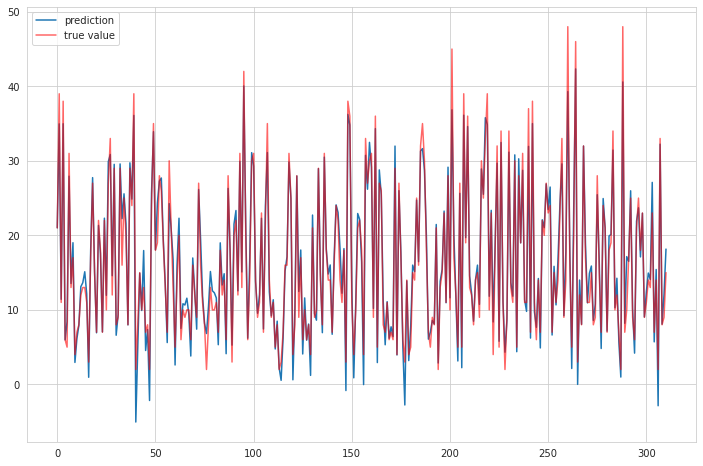

In [194]:
#graph showing predicted values against actual values for 2021
from matplotlib import pyplot as plt

plt.figure(figsize=(12, 8))
plt.plot(vis['prediction'], label='prediction')
plt.plot(vis['HR'], 'r', label='true value', alpha = 0.6)
plt.legend()

## RBI PREDICTOR

In [195]:
RBI_features.show(5)

+---+---+---+---+----+---+-----+-----+-----+-----+-----+----+----+-----+-----+--------+--------+------+----------+----------+--------+----+--------------------+
| PA| AB|  H|  R| RBI|BB%|  ISO|BABIP|  AVG|  OBP|  SLG| GB%| FB%|IFFB%|HR/FB|O-Swing%|Z-Swing%|Swing%|O-Contact%|Z-Contact%|Contact%|  HR|            features|
+---+---+---+---+----+---+-----+-----+-----+-----+-----+----+----+-----+-----+--------+--------+------+----------+----------+--------+----+--------------------+
|259|247| 54| 15|23.0|2.3|0.085|0.237|0.219|0.243|0.304|50.5|29.5|  4.6|  3.1|    43.9|    77.7|  58.9|      70.1|      91.9|    82.9| 2.0|[259.0,247.0,54.0...|
|466|425|113| 73|49.0|7.5|0.205|0.291|0.266| 0.33|0.471|44.6|32.1| 12.4| 12.4|    27.0|    60.4|  42.3|      66.1|      92.7|    83.6|14.0|[466.0,425.0,113....|
|460|413|106| 61|65.0|6.7|0.228|0.284|0.257|0.316|0.484|42.2|38.4|  8.1| 17.1|    33.6|    67.3|  48.1|      58.4|      90.6|    77.8|21.0|[460.0,413.0,106....|
|342|308| 82| 49|47.0|6.7|0.201|  

In [196]:
feature_cols = [x for x in data.columns if x != 'RBI']
assembler = VectorAssembler(inputCols=feature_cols, outputCol='features')

RBI_features = assembler.transform(data)

In [197]:
featurized_data2 = RBI_features.select(['RBI', 'features'])
featurized_data2.show(5)

+----+--------------------+
| RBI|            features|
+----+--------------------+
|23.0|[259.0,247.0,54.0...|
|49.0|[466.0,425.0,113....|
|65.0|[460.0,413.0,106....|
|47.0|[342.0,308.0,82.0...|
|65.0|[412.0,372.0,101....|
+----+--------------------+
only showing top 5 rows



In [198]:
train_RBI, test_RBI = featurized_data2.randomSplit([0.7, 0.3], seed = 1)

In [199]:
scaler = StandardScaler(withMean=True, withStd=True).setInputCol('features') \
        .setOutputCol('scaled_features')
scaler_model = scaler.fit(train_RBI)

train_RBI = scaler_model.transform(train_RBI)
test_RBI = scaler_model.transform(test_RBI)

In [200]:
train_RBI.show(5)

+----+--------------------+--------------------+
| RBI|            features|     scaled_features|
+----+--------------------+--------------------+
|10.0|[281.0,253.0,45.0...|[-1.4263599624844...|
|12.0|[282.0,256.0,69.0...|[-1.4190168042576...|
|12.0|[383.0,335.0,82.0...|[-0.6773578233505...|
|13.0|[256.0,224.0,55.0...|[-1.6099389181545...|
|14.0|[345.0,325.0,87.0...|[-0.9563978359690...|
+----+--------------------+--------------------+
only showing top 5 rows



In [201]:
lr_mod = LR(featuresCol='scaled_features', labelCol= 'RBI', maxIter=100)

RBI_model = lr_mod.fit(train_RBI)

In [202]:
predictions_RBI = RBI_model.transform(test_RBI)
predictions_RBI.show(10)

+----+--------------------+--------------------+------------------+
| RBI|            features|     scaled_features|        prediction|
+----+--------------------+--------------------+------------------+
|13.0|[332.0,311.0,73.0...|[-1.0518588929175...|15.155462043263007|
|14.0|[295.0,253.0,70.0...|[-1.3235557473092...| 22.96555366306319|
|16.0|[269.0,251.0,52.0...|[-1.5144778612060...|  18.6103007434048|
|16.0|[270.0,230.0,36.0...|[-1.5071347029792...|21.204761110099113|
|17.0|[250.0,212.0,53.0...|[-1.6539978675153...|3.7262231873172666|
|17.0|[256.0,225.0,49.0...|[-1.6099389181545...|16.961271583942946|
|17.0|[257.0,214.0,59.0...|[-1.6025957599277...|16.132219636501084|
|19.0|[282.0,257.0,69.0...|[-1.4190168042576...|24.162562648920613|
|19.0|[306.0,279.0,75.0...|[-1.2427810068143...| 25.50425088453251|
|19.0|[313.0,283.0,56.0...|[-1.1913788992267...| 28.28204867876592|
+----+--------------------+--------------------+------------------+
only showing top 10 rows



In [203]:
#train score
metrics = RegressionEvaluator(predictionCol='prediction', labelCol='RBI', metricName= 'rmse')
metrics.evaluate(predictions_RBI)

7.85767110277805

In [204]:
#predict 2021 RBI

featureRBI_2021 = [x for x in data_2021.columns if x != 'RBI']
assembler = VectorAssembler(inputCols=featureRBI_2021, outputCol='features')

data_RBIfeatures21 = assembler.transform(data_2021)

In [205]:
featurized_RBI21 = data_RBIfeatures21.select(['RBI', 'features'])
featurized_RBI21.show(5)

+-----+--------------------+
|  RBI|            features|
+-----+--------------------+
| 69.0|[422.0,384.0,114....|
| 98.0|[633.0,550.0,158....|
| 46.0|[375.0,335.0,80.0...|
|113.0|[555.0,513.0,117....|
| 30.0|[288.0,254.0,51.0...|
+-----+--------------------+
only showing top 5 rows



In [206]:
scaled_RBI21 = scaler_model.transform(featurized_RBI21)

In [207]:
predict_RBI21 = RBI_model.transform(scaled_RBI21)
predict_RBI21.show()

+-----+--------------------+--------------------+------------------+
|  RBI|            features|     scaled_features|        prediction|
+-----+--------------------+--------------------+------------------+
| 69.0|[422.0,384.0,114....|[-0.3909746525052...| 67.17080930276997|
| 98.0|[633.0,550.0,158....|[1.15843173335013...|106.65228689743162|
| 46.0|[375.0,335.0,80.0...|[-0.7361030891649...|38.769561672141336|
|113.0|[555.0,513.0,117....|[0.58566539165951...| 88.84302227010838|
| 30.0|[288.0,254.0,51.0...|[-1.3749578548968...|22.544040081683008|
| 43.0|[639.0,577.0,176....|[1.20249068271095...|56.551639920425124|
| 90.0|[622.0,581.0,141....|[1.07765699285530...| 83.34265202658976|
| 55.0|[461.0,413.0,107....|[-0.1045914816599...|  50.6924654995761|
| 50.0|[296.0,275.0,65.0...|[-1.3162125890824...| 49.47592085640659|
| 28.0|[349.0,319.0,92.0...|[-0.9270252030618...| 28.10894458323024|
| 47.0|[417.0,380.0,94.0...|[-0.4276904436392...|36.380256114376614|
| 45.0|[319.0,294.0,76.0...|[-1.14

In [208]:
print('Test Scores:')
#RMSE
rmse_evaluator = RegressionEvaluator(predictionCol='prediction', labelCol='RBI', metricName= 'rmse')
print('RMSE: ', rmse_evaluator.evaluate(predict_RBI21))

#MSE
mse_evaluator = RegressionEvaluator(labelCol='prediction', predictionCol="RBI", metricName="mse")
print('MSE: ', mse_evaluator.evaluate(predict_RBI21))

#MAE
mae_evaluator = RegressionEvaluator(labelCol="prediction", predictionCol="RBI", metricName="mae")
print('MAE: ', mae_evaluator.evaluate(predict_RBI21))

#R^2
r2_evaluator = RegressionEvaluator(labelCol="prediction", predictionCol="RBI", metricName="r2")
print('R^2: ', r2_evaluator.evaluate(predict_RBI21))

Test Scores:
RMSE:  7.605992905375118
MSE:  57.851128076616625
MAE:  5.7875768164541
R^2:  0.8895331972077563


In [209]:
RBI_vis = predict_RBI21.toPandas()

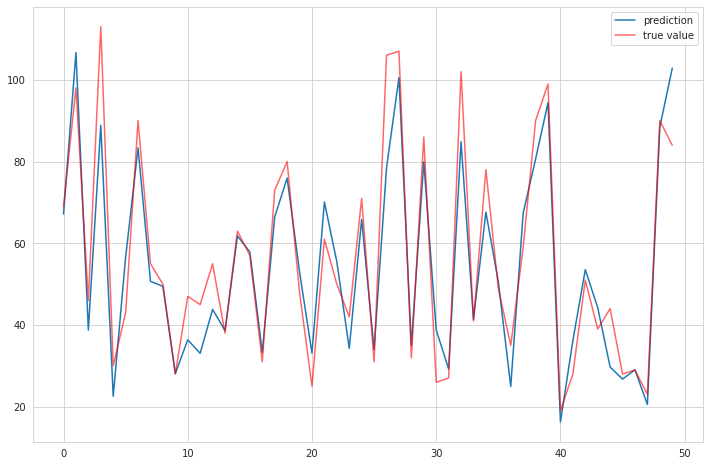

In [210]:
plt.figure(figsize=(12, 8))
plt.plot(RBI_vis['prediction'][:50], label='prediction')
plt.plot(RBI_vis['RBI'][:50], 'r', label='true value', alpha = 0.6)
plt.legend()

## OBP PREDICTOR

In [211]:
OBP_cols = [x for x in data.columns if x != 'OBP']
assembler = VectorAssembler(inputCols=OBP_cols, outputCol='features')

OBP_features = assembler.transform(data)

In [212]:
OBP_featurized = OBP_features.select(['OBP', 'features'])
OBP_featurized.show(5)

+-----+--------------------+
|  OBP|            features|
+-----+--------------------+
|0.243|[259.0,247.0,54.0...|
| 0.33|[466.0,425.0,113....|
|0.316|[460.0,413.0,106....|
|0.327|[342.0,308.0,82.0...|
| 0.34|[412.0,372.0,101....|
+-----+--------------------+
only showing top 5 rows



In [213]:
train_OBP, test_OBP = OBP_featurized.randomSplit([0.7, 0.3], seed = 1)

In [214]:
scaler = StandardScaler(withMean=True, withStd=True).setInputCol('features') \
        .setOutputCol('scaled_features')
scaler_model = scaler.fit(train_OBP)

train_OBP = scaler_model.transform(train_OBP)
test_OBP = scaler_model.transform(test_OBP)

In [215]:
train_OBP.show(5)

+-----+--------------------+--------------------+
|  OBP|            features|     scaled_features|
+-----+--------------------+--------------------+
|0.201|[264.0,251.0,42.0...|[-1.5550023027497...|
|0.232|[288.0,265.0,47.0...|[-1.3801090856028...|
|0.232|[289.0,266.0,44.0...|[-1.3728218682216...|
|0.235|[336.0,301.0,50.0...|[-1.0303226513089...|
|0.243|[259.0,247.0,54.0...|[-1.5914383896553...|
+-----+--------------------+--------------------+
only showing top 5 rows



In [216]:
lr_mod = LR(featuresCol='scaled_features', labelCol= 'OBP', maxIter=100)

OBP_model = lr_mod.fit(train_OBP)

In [217]:
predictions_OBP = OBP_model.transform(test_OBP)
predictions_OBP.show(10)

+-----+--------------------+--------------------+-------------------+
|  OBP|            features|     scaled_features|         prediction|
+-----+--------------------+--------------------+-------------------+
| 0.24|[333.0,319.0,67.0...|[-1.0521843034522...|0.25432589184199145|
| 0.24|[406.0,382.0,76.0...|[-0.5202174346303...|0.24404588871695382|
|0.253|[288.0,266.0,53.0...|[-1.3801090856028...| 0.2636373426586713|
|0.254|[280.0,265.0,58.0...|[-1.4384068246517...| 0.2620434701135558|
|0.254|[281.0,253.0,45.0...|[-1.4311196072706...|0.25487704645174714|
|0.255|[268.0,254.0,55.0...|[-1.5258534332252...| 0.2634190890520497|
|0.255|[458.0,415.0,77.0...|[-0.1412821308119...| 0.2587196609869228|
|0.261|[333.0,310.0,67.0...|[-1.0521843034522...|0.27124326878837074|
|0.265|[260.0,245.0,57.0...|[-1.5841511722742...| 0.2792734673940605|
|0.265|[279.0,259.0,57.0...|[-1.4456940420329...|0.27713327729694964|
+-----+--------------------+--------------------+-------------------+
only showing top 10 

In [218]:
#Train score
metrics = RegressionEvaluator(predictionCol='prediction', labelCol='OBP', metricName= 'rmse')
metrics.evaluate(predictions_OBP)

0.005759167246934036

In [219]:
#predict 2021 OBP
OBP_2021 = [x for x in data_2021.columns if x != 'OBP']
assembler = VectorAssembler(inputCols=OBP_2021, outputCol='features')

OBP_features21 = assembler.transform(data_2021)

In [220]:
featurized_OBP21 = OBP_features21.select(['OBP', 'features'])
featurized_OBP21.show(5)

+-----+--------------------+
|  OBP|            features|
+-----+--------------------+
|0.355|[422.0,384.0,114....|
|0.373|[633.0,550.0,158....|
|0.315|[375.0,335.0,80.0...|
|0.281|[555.0,513.0,117....|
|0.282|[288.0,254.0,51.0...|
+-----+--------------------+
only showing top 5 rows



In [221]:
scaled_OBP21 = scaler_model.transform(featurized_OBP21)

In [222]:
predict_OBP21 = OBP_model.transform(scaled_OBP21)
predict_OBP21.show()

+-----+--------------------+--------------------+-------------------+
|  OBP|            features|     scaled_features|         prediction|
+-----+--------------------+--------------------+-------------------+
|0.355|[422.0,384.0,114....|[-0.4036219565323...| 0.3504241306000557|
|0.373|[633.0,550.0,158....|[1.13398091088444...|0.37841909325125017|
|0.315|[375.0,335.0,80.0...|[-0.7461211734451...|0.30877296828425094|
|0.281|[555.0,513.0,117....|[0.56557795515689...|0.27777509677655143|
|0.282|[288.0,254.0,51.0...|[-1.3801090856028...|0.27442104214780055|
|0.368|[639.0,577.0,176....|[1.17770421517118...| 0.3624770108391862|
|0.286|[622.0,581.0,141....|[1.05382151969210...|  0.282590178658525|
| 0.33|[461.0,413.0,107....|[-0.1194204786686...| 0.3343453432668885|
|0.284|[296.0,275.0,65.0...|[-1.3218113465538...| 0.2843537091470829|
| 0.34|[349.0,319.0,92.0...|[-0.9355888253543...|0.33295317140940806|
|0.305|[417.0,380.0,94.0...|[-0.4400580434380...| 0.3079028501203004|
|0.317|[319.0,294.0,

In [223]:
print('Test Scores:')
#RMSE
rmse_evaluator = RegressionEvaluator(predictionCol='prediction', labelCol='OBP', metricName= 'rmse')
print('RMSE: ', rmse_evaluator.evaluate(predict_OBP21))

#MSE
mse_evaluator = RegressionEvaluator(labelCol='prediction', predictionCol="OBP", metricName="mse")
print('MSE: ', mse_evaluator.evaluate(predict_OBP21))

#MAE
mae_evaluator = RegressionEvaluator(labelCol="prediction", predictionCol="OBP", metricName="mae")
print('MAE: ', mae_evaluator.evaluate(predict_OBP21))

#R^2
r2_evaluator = RegressionEvaluator(labelCol="prediction", predictionCol="OBP", metricName="r2")
print('R^2: ', r2_evaluator.evaluate(predict_OBP21))

Test Scores:
RMSE:  0.005594852775643846
MSE:  3.130237758112965e-05
MAE:  0.004203419089624771
R^2:  0.9731968849311254


In [224]:
OBP_vis = predict_OBP21.toPandas()

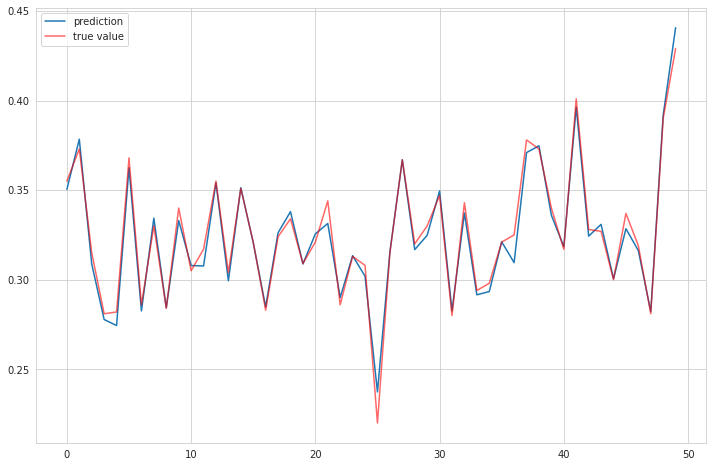

In [225]:
plt.figure(figsize=(12, 8))
plt.plot(OBP_vis['prediction'][:50], label='prediction')
plt.plot(OBP_vis['OBP'][:50], 'r', label='true value', alpha = 0.6)
plt.legend()

# XGBoost

### HR

In [226]:
#create the xgboost estimator
from xgboost.spark import SparkXGBRegressor

xgb_regressor = SparkXGBRegressor(
  features_col="features",
  label_col="HR",
  num_workers=2
)

#train on the same data that was preprocessed to predict HR
xgb_model = xgb_regressor.fit(HRtrain)

predictor = xgb_model.transform(HRtest)

predictor.show(10)

/usr/local/lib/python3.9/dist-packages/xgboost/sklearn.py:782: UserWarning: Loading a native XGBoost model with Scikit-Learn interface.
  warnings.warn("Loading a native XGBoost model with Scikit-Learn interface.")


+---+--------------------+--------------------+------------------+
| HR|            features|     scaled_features|        prediction|
+---+--------------------+--------------------+------------------+
|0.0|[353.0,316.0,69.0...|[-0.9056481340034...|0.5158592462539673|
|1.0|[250.0,212.0,53.0...|[-1.6527052004938...|  1.02872896194458|
|1.0|[337.0,299.0,83.0...|[-1.0216958336524...| 0.678517758846283|
|1.0|[345.0,325.0,87.0...|[-0.9636719838279...|0.7656716704368591|
|1.0|[365.0,327.0,95.0...|[-0.8186123592667...|1.0167473554611206|
|1.0|[393.0,326.0,86.0...|[-0.6155288848810...|0.9004303812980652|
|1.0|[411.0,359.0,94.0...|[-0.4849752227759...|1.7606106996536255|
|2.0|[332.0,311.0,88.0...|[-1.0579607397927...|2.3479416370391846|
|2.0|[375.0,350.0,76.0...|[-0.7460825469861...|2.1762540340423584|
|2.0|[383.0,335.0,82.0...|[-0.6880586971616...|3.0088815689086914|
+---+--------------------+--------------------+------------------+
only showing top 10 rows



In [227]:
#Train scores
#RMSE
rmse_evaluator = RegressionEvaluator(predictionCol='prediction', labelCol='HR', metricName= 'rmse')
print('RMSE: ', rmse_evaluator.evaluate(predictor))

#MSE
mse_evaluator = RegressionEvaluator(labelCol='prediction', predictionCol="HR", metricName="mse")
print('MSE: ', mse_evaluator.evaluate(predictor))

#MAE
mae_evaluator = RegressionEvaluator(labelCol="prediction", predictionCol="HR", metricName="mae")
print('MAE: ', mae_evaluator.evaluate(predictor))

#R^2
r2_evaluator = RegressionEvaluator(labelCol="prediction", predictionCol="HR", metricName="r2")
print('R^2: ', r2_evaluator.evaluate(predictor))

RMSE:  1.7598256794480744
MSE:  3.0969864220448766
MAE:  1.3086689888128167
R^2:  0.9689543207848077


In [228]:
#predict 2021 HR values using xgb
HR_predict2021 = xgb_model.transform(scaled_2021)
HR_predict2021.show()

+----+--------------------+--------------------+------------------+
|  HR|            features|     scaled_features|        prediction|
+----+--------------------+--------------------+------------------+
|21.0|[422.0,384.0,114....|[-0.4051924292672...|21.497867584228516|
|39.0|[633.0,550.0,158....|[1.12518660985377...|36.021976470947266|
|11.0|[375.0,335.0,80.0...|[-0.7460825469861...| 9.287363052368164|
|38.0|[555.0,513.0,117....|[0.55945407406496...| 33.73423385620117|
| 6.0|[288.0,254.0,51.0...|[-1.3770919138275...| 6.410921096801758|
| 5.0|[639.0,577.0,176....|[1.16870449722214...| 4.813116550445557|
|31.0|[622.0,581.0,141....|[1.04540381634509...| 31.46219253540039|
|13.0|[461.0,413.0,107....|[-0.1223261613728...|13.733752250671387|
|17.0|[296.0,275.0,65.0...|[-1.3190680640030...| 14.75114917755127|
| 4.0|[349.0,319.0,92.0...|[-0.9346600589157...|  4.45363712310791|
| 7.0|[417.0,380.0,94.0...|[-0.4414573354075...| 9.836956977844238|
| 8.0|[319.0,294.0,76.0...|[-1.1522494957575...|

In [229]:
#Test scores
#RMSE
rmse_evaluator = RegressionEvaluator(predictionCol='prediction', labelCol='HR', metricName= 'rmse')
print('RMSE: ', rmse_evaluator.evaluate(HR_predict2021))

#MSE
mse_evaluator = RegressionEvaluator(labelCol='prediction', predictionCol="HR", metricName="mse")
print('MSE: ', mse_evaluator.evaluate(HR_predict2021))

#MAE
mae_evaluator = RegressionEvaluator(labelCol="prediction", predictionCol="HR", metricName="mae")
print('MAE: ', mae_evaluator.evaluate(HR_predict2021))

#R^2
r2_evaluator = RegressionEvaluator(labelCol="prediction", predictionCol="HR", metricName="r2")
print('R^2: ', r2_evaluator.evaluate(HR_predict2021))

RMSE:  1.8500223893897356
MSE:  3.422582841243307
MAE:  1.3212337792877982
R^2:  0.9642878118565301


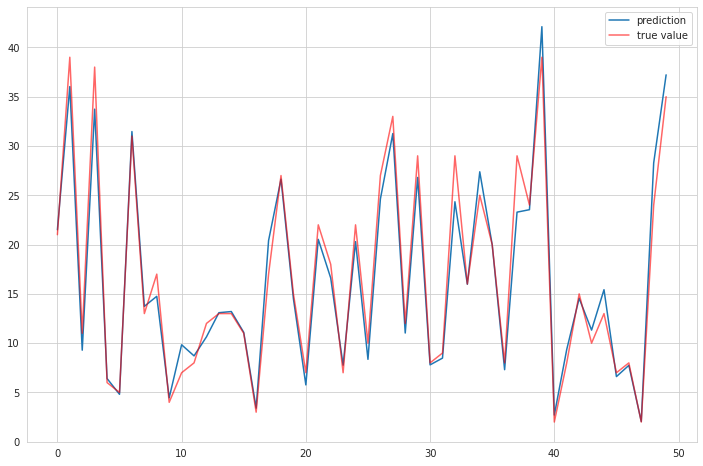

In [231]:
graph = HR_predict2021.toPandas()
plt.figure(figsize=(12, 8))
plt.plot(graph['prediction'][:50], label='prediction')
plt.plot(graph['HR'][:50], 'r', label='true value', alpha = 0.6)
plt.legend()

### RBI

In [232]:
xgb_regressor = SparkXGBRegressor(
  features_col="features",
  label_col="RBI",
  num_workers=2
)

#train using the preprocessed data used to predict RBI above
xgb_model = xgb_regressor.fit(train_RBI)

RBI_predictor = xgb_model.transform(test_RBI)
RBI_predictor.show()

/usr/local/lib/python3.9/dist-packages/xgboost/sklearn.py:782: UserWarning: Loading a native XGBoost model with Scikit-Learn interface.
  warnings.warn("Loading a native XGBoost model with Scikit-Learn interface.")


+----+--------------------+--------------------+------------------+
| RBI|            features|     scaled_features|        prediction|
+----+--------------------+--------------------+------------------+
|13.0|[332.0,311.0,73.0...|[-1.0518588929175...|15.575478553771973|
|14.0|[295.0,253.0,70.0...|[-1.3235557473092...|19.961830139160156|
|16.0|[269.0,251.0,52.0...|[-1.5144778612060...|19.722217559814453|
|16.0|[270.0,230.0,36.0...|[-1.5071347029792...|25.064306259155273|
|17.0|[250.0,212.0,53.0...|[-1.6539978675153...| 18.99720001220703|
|17.0|[256.0,225.0,49.0...|[-1.6099389181545...|16.294763565063477|
|17.0|[257.0,214.0,59.0...|[-1.6025957599277...|15.978949546813965|
|19.0|[282.0,257.0,69.0...|[-1.4190168042576...|25.058225631713867|
|19.0|[306.0,279.0,75.0...|[-1.2427810068143...|21.942550659179688|
|19.0|[313.0,283.0,56.0...|[-1.1913788992267...|28.435705184936523|
|20.0|[256.0,217.0,41.0...|[-1.6099389181545...| 28.17243766784668|
|20.0|[291.0,265.0,68.0...|[-1.3529283802164...|

In [233]:
#Train scores
#RMSE
rmse_evaluator = RegressionEvaluator(predictionCol='prediction', labelCol='RBI', metricName= 'rmse')
print('RMSE: ', rmse_evaluator.evaluate(RBI_predictor))

#MSE
mse_evaluator = RegressionEvaluator(labelCol='prediction', predictionCol="RBI", metricName="mse")
print('MSE: ', mse_evaluator.evaluate(RBI_predictor))

#MAE
mae_evaluator = RegressionEvaluator(labelCol="prediction", predictionCol="RBI", metricName="mae")
print('MAE: ', mae_evaluator.evaluate(RBI_predictor))

#R^2
r2_evaluator = RegressionEvaluator(labelCol="prediction", predictionCol="RBI", metricName="r2")
print('R^2: ', r2_evaluator.evaluate(RBI_predictor))

RMSE:  9.019844387875443
MSE:  81.35759278148814
MAE:  7.195570732075009
R^2:  0.8561580831973358


In [234]:
#predict RBI 2021 using 2021 dataset
RBI_predict2021 = xgb_model.transform(scaled_RBI21)
RBI_predict2021.show()

+-----+--------------------+--------------------+------------------+
|  RBI|            features|     scaled_features|        prediction|
+-----+--------------------+--------------------+------------------+
| 69.0|[422.0,384.0,114....|[-0.3909746525052...| 65.66358947753906|
| 98.0|[633.0,550.0,158....|[1.15843173335013...| 110.6928482055664|
| 46.0|[375.0,335.0,80.0...|[-0.7361030891649...| 40.41550064086914|
|113.0|[555.0,513.0,117....|[0.58566539165951...|  79.8534164428711|
| 30.0|[288.0,254.0,51.0...|[-1.3749578548968...|31.288877487182617|
| 43.0|[639.0,577.0,176....|[1.20249068271095...| 41.27515411376953|
| 90.0|[622.0,581.0,141....|[1.07765699285530...| 89.22401428222656|
| 55.0|[461.0,413.0,107....|[-0.1045914816599...|  54.9765739440918|
| 50.0|[296.0,275.0,65.0...|[-1.3162125890824...| 37.02912902832031|
| 28.0|[349.0,319.0,92.0...|[-0.9270252030618...| 26.01109504699707|
| 47.0|[417.0,380.0,94.0...|[-0.4276904436392...|   40.013427734375|
| 45.0|[319.0,294.0,76.0...|[-1.14

In [235]:
#Test scores
#RMSE
rmse_evaluator = RegressionEvaluator(predictionCol='prediction', labelCol='RBI', metricName= 'rmse')
print('RMSE: ', rmse_evaluator.evaluate(RBI_predict2021))

#MSE
mse_evaluator = RegressionEvaluator(labelCol='prediction', predictionCol="RBI", metricName="mse")
print('MSE: ', mse_evaluator.evaluate(RBI_predict2021))

#MAE
mae_evaluator = RegressionEvaluator(labelCol="prediction", predictionCol="RBI", metricName="mae")
print('MAE: ', mae_evaluator.evaluate(RBI_predict2021))

#R^2
r2_evaluator = RegressionEvaluator(labelCol="prediction", predictionCol="RBI", metricName="r2")
print('R^2: ', r2_evaluator.evaluate(RBI_predict2021))

RMSE:  9.28098439011507
MSE:  86.13667124955957
MAE:  7.182887068132112
R^2:  0.8470123458748609


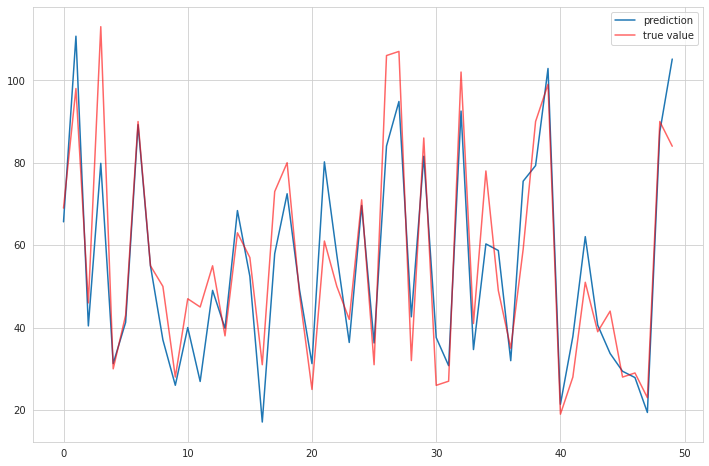

In [236]:
graph = RBI_predict2021.toPandas()
plt.figure(figsize=(12, 8))
plt.plot(graph['prediction'][:50], label='prediction')
plt.plot(graph['RBI'][:50], 'r', label='true value', alpha = 0.6)
plt.legend()

### OBP

In [237]:
xgb_regressor = SparkXGBRegressor(
  features_col="features",
  label_col="OBP",
  num_workers=2
)

#train model using preprocesssed data that predicted OBP above
xgb_model = xgb_regressor.fit(train_OBP)

OBP_predictor = xgb_model.transform(test_OBP)
OBP_predictor.show()

/usr/local/lib/python3.9/dist-packages/xgboost/sklearn.py:782: UserWarning: Loading a native XGBoost model with Scikit-Learn interface.
  warnings.warn("Loading a native XGBoost model with Scikit-Learn interface.")


+-----+--------------------+--------------------+-------------------+
|  OBP|            features|     scaled_features|         prediction|
+-----+--------------------+--------------------+-------------------+
| 0.24|[333.0,319.0,67.0...|[-1.0521843034522...|0.26104050874710083|
| 0.24|[406.0,382.0,76.0...|[-0.5202174346303...|0.25646111369132996|
|0.253|[288.0,266.0,53.0...|[-1.3801090856028...| 0.2673967182636261|
|0.254|[280.0,265.0,58.0...|[-1.4384068246517...| 0.2665465176105499|
|0.254|[281.0,253.0,45.0...|[-1.4311196072706...|0.24980762600898743|
|0.255|[268.0,254.0,55.0...|[-1.5258534332252...| 0.2557353973388672|
|0.255|[458.0,415.0,77.0...|[-0.1412821308119...|0.25584545731544495|
|0.261|[333.0,310.0,67.0...|[-1.0521843034522...|0.26560452580451965|
|0.265|[260.0,245.0,57.0...|[-1.5841511722742...| 0.2823161482810974|
|0.265|[279.0,259.0,57.0...|[-1.4456940420329...|0.25931498408317566|
|0.265|[334.0,304.0,63.0...|[-1.0448970860711...| 0.2704572081565857|
|0.267|[457.0,427.0,

In [238]:
#Train scores
#RMSE
rmse_evaluator = RegressionEvaluator(predictionCol='prediction', labelCol='OBP', metricName= 'rmse')
print('RMSE: ', rmse_evaluator.evaluate(OBP_predictor))

#MSE
mse_evaluator = RegressionEvaluator(labelCol='prediction', predictionCol="OBP", metricName="mse")
print('MSE: ', mse_evaluator.evaluate(OBP_predictor))

#MAE
mae_evaluator = RegressionEvaluator(labelCol="prediction", predictionCol="OBP", metricName="mae")
print('MAE: ', mae_evaluator.evaluate(OBP_predictor))

#R^2
r2_evaluator = RegressionEvaluator(labelCol="prediction", predictionCol="OBP", metricName="r2")
print('R^2: ', r2_evaluator.evaluate(OBP_predictor))

RMSE:  0.007947770225739151
MSE:  6.316705156114575e-05
MAE:  0.006121089793945271
R^2:  0.946186945545804


In [239]:
#predict OBP 2021
OBP_predict2021 = xgb_model.transform(scaled_OBP21)
OBP_predict2021.show()

+-----+--------------------+--------------------+-------------------+
|  OBP|            features|     scaled_features|         prediction|
+-----+--------------------+--------------------+-------------------+
|0.355|[422.0,384.0,114....|[-0.4036219565323...|0.35459429025650024|
|0.373|[633.0,550.0,158....|[1.13398091088444...|0.37150365114212036|
|0.315|[375.0,335.0,80.0...|[-0.7461211734451...|0.30789610743522644|
|0.281|[555.0,513.0,117....|[0.56557795515689...| 0.2939826548099518|
|0.282|[288.0,254.0,51.0...|[-1.3801090856028...| 0.2605644762516022|
|0.368|[639.0,577.0,176....|[1.17770421517118...|0.35505518317222595|
|0.286|[622.0,581.0,141....|[1.05382151969210...| 0.2862529754638672|
| 0.33|[461.0,413.0,107....|[-0.1194204786686...|0.33176109194755554|
|0.284|[296.0,275.0,65.0...|[-1.3218113465538...|0.26720109581947327|
| 0.34|[349.0,319.0,92.0...|[-0.9355888253543...|0.32860690355300903|
|0.305|[417.0,380.0,94.0...|[-0.4400580434380...|0.31340113282203674|
|0.317|[319.0,294.0,

In [240]:
#Test scores
#RMSE
rmse_evaluator = RegressionEvaluator(predictionCol='prediction', labelCol='OBP', metricName= 'rmse')
print('RMSE: ', rmse_evaluator.evaluate(OBP_predict2021))

#MSE
mse_evaluator = RegressionEvaluator(labelCol='prediction', predictionCol="OBP", metricName="mse")
print('MSE: ', mse_evaluator.evaluate(OBP_predict2021))

#MAE
mae_evaluator = RegressionEvaluator(labelCol="prediction", predictionCol="OBP", metricName="mae")
print('MAE: ', mae_evaluator.evaluate(OBP_predict2021))

#R^2
r2_evaluator = RegressionEvaluator(labelCol="prediction", predictionCol="OBP", metricName="r2")
print('R^2: ', r2_evaluator.evaluate(OBP_predict2021))

RMSE:  0.00891352472040836
MSE:  7.945092294133094e-05
MAE:  0.0067326019718716
R^2:  0.9313327300433927


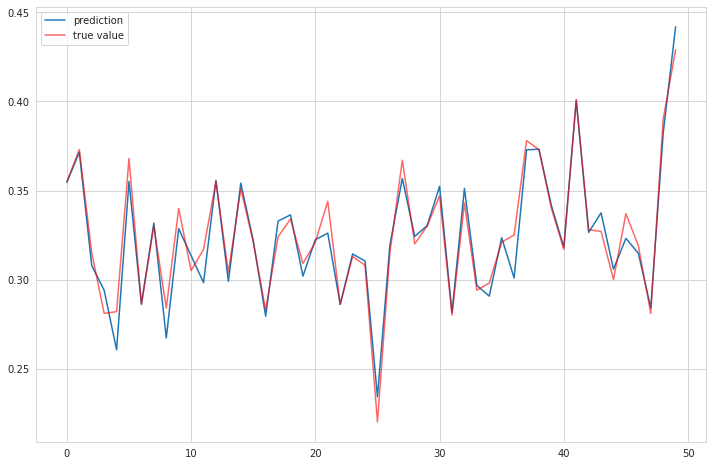

In [242]:
graph = OBP_predict2021.toPandas()
plt.figure(figsize=(12, 8))
plt.plot(graph['prediction'][:50], label='prediction')
plt.plot(graph['OBP'][:50], 'r', label='true value', alpha = 0.6)
plt.legend()